2.3.1. Загрузка данных и первичный анализ

In [35]:
import pandas as pd
import numpy as np
import sklearn

df = pd.read_csv("data/S05-hw-dataset.csv")
print(df.head())
print(df.info())
print(df.describe())
print(df['default'].value_counts(normalize=True))


   client_id  age  income  years_employed  credit_score  debt_to_income  \
0          1   25   94074              22           839        0.547339   
1          2   58   51884              26           565        0.290882   
2          3   53   48656              39           561        0.522340   
3          4   42   81492              30           582        0.709123   
4          5   42   94713               8           642        0.793392   

   num_credit_cards  num_late_payments  has_mortgage  has_car_loan  \
0                 1                  7             0             0   
1                 1                  1             0             1   
2                 1                 13             0             0   
3                 2                 10             1             1   
4                 3                  3             0             0   

   savings_balance  checking_balance  region_risk_score  \
0            26057              5229           0.080052   
1         

### Наблюдения по первичному анализу данных:

- **Размер датасета**: 3000 строк (объектов) и 17 столбцов (признаков)
- **Аномалии**: Явных аномалий не обнаружено. Все значения находятся в разумных диапазонах (возраст 21-69 лет, доход 15000-156351, кредитный скоринг 402-850 и т.д.)
- **Распределение таргета**: Целевой признак `default` распределён примерно 60% (класс 0 - без дефолта) и 40% (класс 1 - с дефолтом). Задача умеренно несбалансирована, но не критично.

In [6]:
valid_mask = pd.Series([True] * len(df), index=df.index)
valid_mask &= (df['age'] >= 18) & (df['age'] <= 100)
valid_mask &= (df['income'] >= 0) & (df['income'] <= 1_000_000)
valid_mask &= (df['years_employed'] >= 0) & (df['years_employed'] <= df['age'])
valid_mask &= (df['credit_score'] >= 300) & (df['credit_score'] <= 850)
valid_mask &= (df['debt_to_income'] >= 0) & (df['debt_to_income'] <= 1)
valid_mask &= (df['num_credit_cards'] >= 0) & (df['num_credit_cards'] <= 10)
valid_mask &= (df['num_late_payments'] >= 0)
valid_mask &= df['has_mortgage'].isin([0, 1])
valid_mask &= df['has_car_loan'].isin([0, 1])
valid_mask &= (df['savings_balance'] >= 0)
valid_mask &= (df['checking_balance'] >= -100_000) & (df['checking_balance'] <= 1_000_000)
valid_mask &= (df['region_risk_score'] >= 0) & (df['region_risk_score'] <= 1)
valid_mask &= (df['phone_calls_to_support_last_3m'] >= 0)
valid_mask &= (df['active_loans'] >= 0)
valid_mask &= (df['customer_tenure_years'] >= 0) & (df['customer_tenure_years'] <= df['age'])
df_clean = df[valid_mask].copy()

y = df_clean['default']
X = df_clean.drop(columns=['client_id', 'default'])

         client_id          age         income  years_employed  credit_score  \
count  3000.000000  3000.000000    3000.000000     3000.000000   3000.000000   
mean   1500.500000    45.059667   69658.992000       19.577667    649.285333   
std     866.169729    14.192883   24742.235182       11.381497     69.955852   
min       1.000000    21.000000   15000.000000        0.000000    402.000000   
25%     750.750000    33.000000   52641.750000       10.000000    604.000000   
50%    1500.500000    45.000000   69784.500000       20.000000    647.000000   
75%    2250.250000    57.000000   85874.250000       29.000000    697.000000   
max    3000.000000    69.000000  156351.000000       39.000000    850.000000   

       debt_to_income  num_credit_cards  num_late_payments  has_mortgage  \
count     3000.000000       3000.000000        3000.000000   3000.000000   
mean         0.284065          3.494667           6.869333      0.495000   
std          0.161112          2.289917           4

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)
dummy = DummyClassifier(strategy="stratified")
dummy.fit(X_train, y_train)

y_pred = dummy.predict(X_test)
y_proba = dummy.predict_proba(X_test)[:, 1]

acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)

print(f"Accuracy: {acc:.4f}")
print(f"ROC-AUC:  {roc_auc:.4f}")
print(dummy)

(2250, 15)
(750, 15)
(2250,)
(750,)
Accuracy: 0.5427
ROC-AUC:  0.4993
DummyClassifier(strategy='stratified')


2.3.4. Логистическая регрессия и подбор гиперпараметров

In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000))
])

from sklearn.model_selection import GridSearchCV

param_grid = {
    'logreg__C': [0.01, 0.1, 1.0, 10.0, 100.0]
}

grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train, y_train)

print("C:", grid_search.best_params_)
print("ROC-AUC:", grid_search.best_score_)


C: {'logreg__C': 1.0}
ROC-AUC: 0.8631695636003741


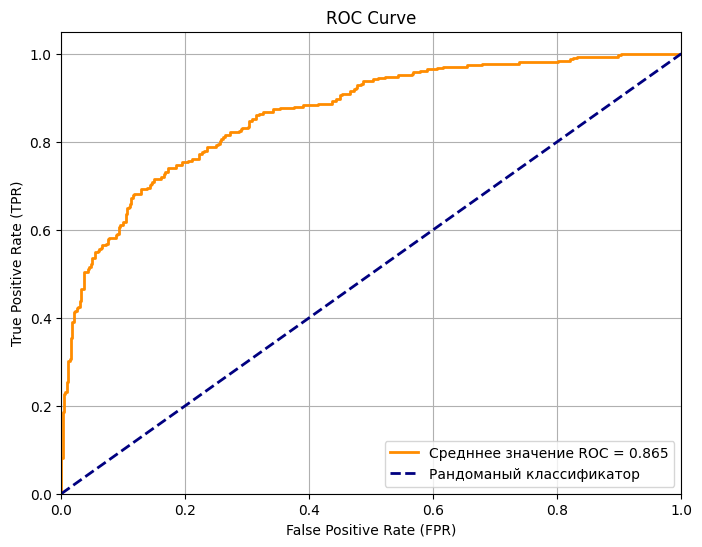

In [28]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

pipe = Pipeline([
    ("scaler", StandardScaler()),
    ("logreg", LogisticRegression(max_iter=1000, C=1, solver="lbfgs"))
])
grid_search = GridSearchCV(
    pipe,
    param_grid,
    cv=5,
    scoring='roc_auc'
)
grid_search.fit(X_train, y_train)

y_proba = grid_search.predict_proba(X_test)[:, 1]



# Считаем ROC-кривую
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# Строим график
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Средннее значение ROC = {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Рандоманый классификатор')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.savefig("figures/plot_ROC.png")
plt.show()

In [31]:
y_pred_dummy = dummy.predict(X_test)
y_proba_dummy = dummy.predict_proba(X_test)[:, 1]

acc_dummy = accuracy_score(y_test, y_pred_dummy)
auc_dummy = roc_auc_score(y_test, y_proba_dummy)

y_pred_lr = grid_search.predict(X_test)
y_proba_lr = grid_search.predict_proba(X_test)[:, 1]

acc_lr = accuracy_score(y_test, y_pred_lr)
auc_lr = roc_auc_score(y_test, y_proba_lr)

results = pd.DataFrame({
    "Model": ["Dummy", "Logistic Regression"],
    "Accuracy": [acc_dummy, acc_lr],
    "ROC-AUC": [auc_dummy, auc_lr]
}).round(4)

print(results)

                 Model  Accuracy  ROC-AUC
0                Dummy    0.5160   0.5045
1  Logistic Regression    0.7933   0.8647


2.3.5. Сравнение бейзлайна и логистической регрессии, текстовые выводы


Логистическая регрессия оказалась лучшее по качеству по сравнению с бейзлайном . Бейзлайн, который просто предсказывает классы случайным образом с учётом распределения, достиг accuracy 0.5160 и ROC-AUC 0.5045, что практически равно случайному угадыванию. Логистическая регрессия с лучшими параметрами показала accuracy 0.7933 и ROC-AUC 0.8647.

По сравнению с бейзлайном, accuracy выросла примерно на 54% (с 0.5160 до 0.7933), а ROC-AUC увеличилась на 71% (с 0.5045 до 0.8647). Это говорит о том, что модель действительно научилась находить закономерности в данных и делать осмысленные предсказания.

При подборе гиперпараметра регуляризации C были проверены значения [0.01, 0.1, 1.0, 10.0, 100.0]. Лучший результат показало значение C=1.0. При меньших значениях C (0.01, 0.1) модель была слишком сильно регуляризована и не могла достаточно хорошо выучить закономерности. При больших значениях C (10.0, 100.0) регуляризация была слишком слабой, что могло привести к переобучению. Значение C=1.0 оказалось оптимальным балансом между способностью модели выучить паттерны и устойчивостью к переобучению.

Тут предсказания дефолта логистическая регрессия является адекватным выбором, так как она показывает хорошее качество (ROC-AUC 0.86), интерпретируема и быстро обучается. Модель успешно использует признаки клиентов для предсказания вероятности дефолта, что намного лучше простого случайного угадывания
